Because it looks like the different selection modes amount to a difference in temperature, try to enforce this

In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

## Generate

In [295]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/callback.py'>

In [296]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")
tr.add_node(0, name = "R02F")
tr.add_node(0, name = "R02S")
tr.add_node(0, name = "R02SF")

picked_round_idx = [0, 1, 3, 4, 5, 6]

mode_names = ["NA, NW", "FA, NW", "NA, HW", "FA, HW", "unbound"]
mode_names_rounds = [mode_names[i] for i in [0] + list(range(len(mode_names)))]

selected_modes = torch.BoolTensor(
    [[1, 0, 0, 0, 0],
     [1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [361]:
L, q = 5, 2

k_teacher = torch.randn(L, q, dtype=dtype)
h_teacher = torch.randn(L, q, dtype=dtype)

h_teacher = torch.randn(L, q, dtype=dtype)
J_teacher = utils.rand_coupling_matrix(L, q, dtype=dtype)
potts_teacher = energy_models.Potts(J_teacher, h_teacher)
potts_modes_teacher = [potts_teacher for _ in range(n_modes-1)]

Ns0_teacher = energy_models.IndepSites(k_teacher)
unbound_mode_teacher = energy_models.ConstantEnergy(-10)

alpha = torch.rand(n_selection_rounds, dtype=dtype)
alpha /= alpha.sum(0, keepdim=True)

ps_teacher = selex_distribution.MultiModeDistribution(*potts_modes_teacher, unbound_mode_teacher, normalized=True)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes, 
                                                         selection_strength=alpha)

In [362]:
n_chains = 10**5
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [363]:
n_sweeps = 20
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [364]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

## Learn

In [365]:
k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype, rescaling=1e-4)
potts = energy_models.Potts(J, h)
potts_modes = [potts for _ in range(n_modes - 1)]

Ns0 = energy_models.IndepSites(k)
unbound_mode = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(*potts_modes, unbound_mode, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, 
                                                  learn_selection_strength=True,
                                                  selection_strength = torch.rand(n_selection_rounds, dtype=dtype))

In [366]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [367]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [368]:
# import importlib
# importlib.reload(utils)
# importlib.reload(selex_distribution)
# importlib.reload(energy_models)
# importlib.reload(sampling)
# importlib.reload(training)
# importlib.reload(callback)

In [369]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [370]:
lr = 0.01
optimizer = torch.optim.Adam([
                            {'params': model.parameters(), 'lr': lr}
                        ])

In [398]:
n_sweeps = 10
target_pearson = 1
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, 
               callbacks=callbacks, log_weights=log_weights,
               optimizer = optimizer)

 0.00%[                             ] Epoch: 0/1000 [00:00, ?it/s]

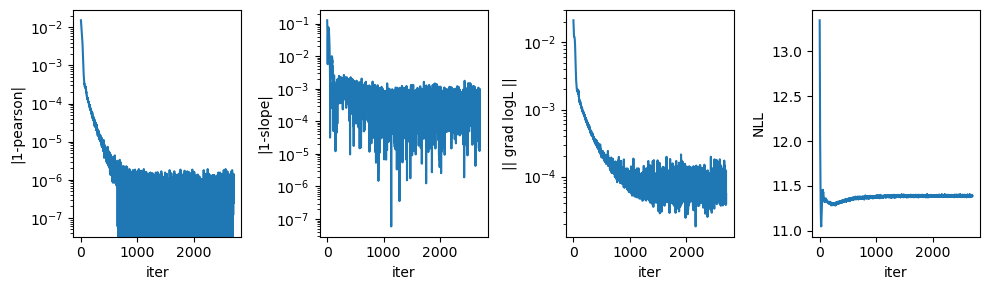

In [409]:
callbacks[0].plot();

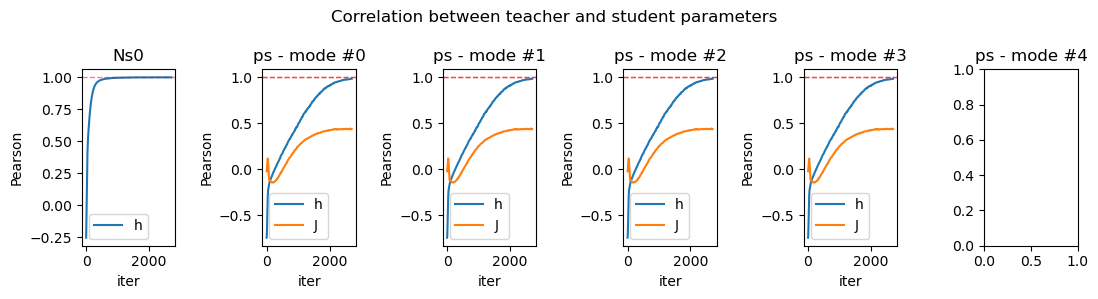

In [410]:
callbacks[1].plot(figsize=(11, 3));

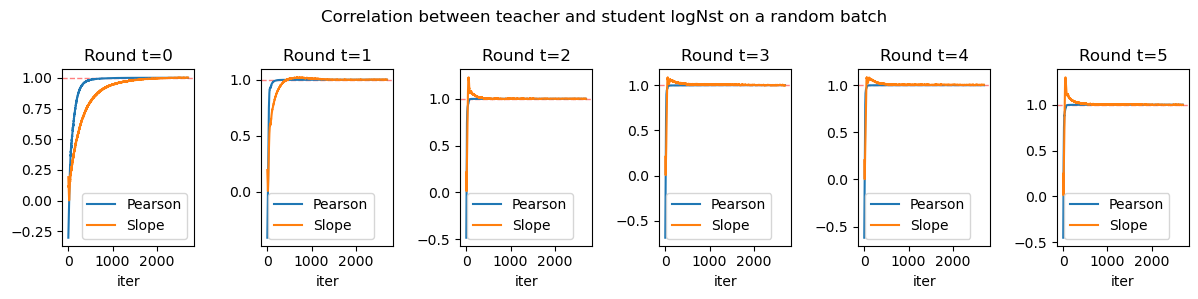

In [411]:
callbacks[1].plot_energies(figsize=(12, 3));

In [412]:
alpha

tensor([0.2308, 0.1023, 0.3018, 0.1471, 0.2180])

In [413]:
model.selection_strength

Parameter containing:
tensor([0.1838, 0.0780, 0.2331, 0.1283, 0.1691], requires_grad=True)

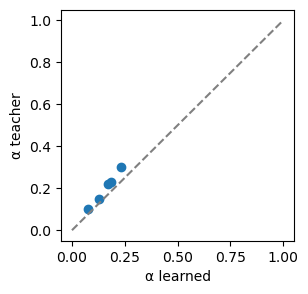

In [414]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(model.selection_strength.detach(), alpha)
ax.plot((0,1), (0,1), ls='--', color='gray')
ax.set_xlabel('α learned'); ax.set_ylabel('α teacher');

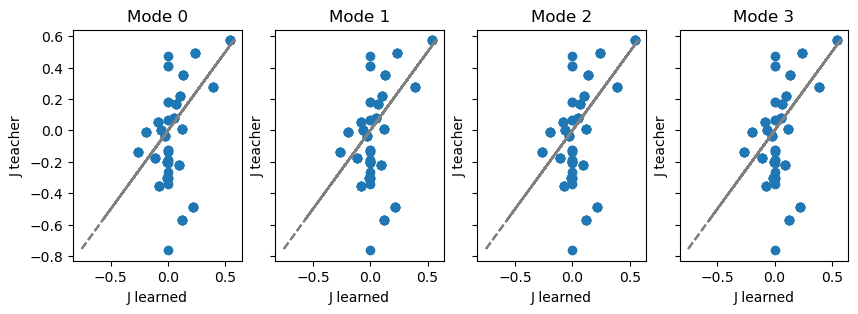

In [415]:
fig, axes = plt.subplots(1, 4, figsize = (10,3), sharex=True, sharey=True)
for i in range(n_modes-1):
    ax = axes[i]
    x = model.selection.modes[i].set_zerosum_gauge().J.detach().reshape(-1)
    y = model_teacher.selection.modes[i].set_zerosum_gauge().J.detach().reshape(-1)
    ax.plot(y, y,ls='--', color='gray', alpha=1)
    ax.scatter(x, y)
    ax.set_xlabel('J learned'); ax.set_ylabel('J teacher')
    ax.set_title(f'Mode {i}')

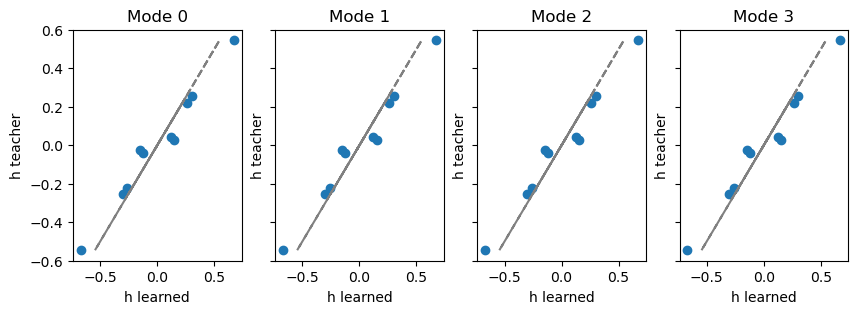

In [416]:
fig, axes = plt.subplots(1, 4, figsize = (10,3), sharex=True, sharey=True)
for i in range(n_modes-1):
    ax = axes[i]
    x = model.selection.modes[i].set_zerosum_gauge().h.detach().reshape(-1)
    y = model_teacher.selection.modes[i].set_zerosum_gauge().h.detach().reshape(-1)
    ax.scatter(x, y)
    ax.plot(y, y,ls='--', color='gray', alpha=1)
    ax.set_xlabel('h learned'); ax.set_ylabel('h teacher')
    ax.set_title(f'Mode {i}')